In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [8]:
df_Cigni

,M,R,T,H,He3,He4,C12,N14,O16,H2,...,Ti48,Cr48,Cr52,Fe52,Fe56,Ni56,P,A,N,COfrac
MESH,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,216220900.0,0.000000,0.000000,0.987851,0.012060,2.215681e-05,0.00006,3.194737e-28,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.012121
2,0.000080,0.008523,216209700.0,0.000000,0.000000,0.987851,0.012060,2.215681e-05,0.00006,3.194737e-28,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.012121
3,0.000082,0.008609,216209400.0,0.000000,0.000000,0.987851,0.012060,2.215681e-05,0.00006,3.194737e-28,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.012121
4,0.000085,0.008693,216209200.0,0.000000,0.000000,0.987851,0.012060,2.215681e-05,0.00006,3.194737e-28,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.012121
5,0.000087,0.008775,216209000.0,0.000000,0.000000,0.987851,0.012060,2.215681e-05,0.00006,3.194737e-28,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.012121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,148.255542,14.288150,5496941.0,0.759893,0.000076,0.240000,0.000004,6.951122e-07,0.00002,1.013934e-17,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.000025
737,148.316159,14.384700,5417686.0,0.759893,0.000076,0.240000,0.000004,6.951122e-07,0.00002,1.023162e-17,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.000025
738,148.376776,14.483920,5336989.0,0.759893,0.000076,0.240000,0.000004,6.951122e-07,0.00002,1.032786e-17,...,4.631784e-09,0.0,1.399949e-08,0.0,0.000001,0.0,0.0,0.0,0.0,0.000025


In [27]:
df.loc[:, 'T']

MESH
1      125678500.0
2      125670600.0
3      125670500.0
4      125670300.0
5      125670200.0
          ...     
681      5974466.0
682      5928067.0
683      5881099.0
684      5833541.0
685      5785368.0
Name: T, Length: 685, dtype: float64

In [47]:
# init_mass_arr = np.arange(70, 151, 10)
# CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
# for i, init_mass in enumerate(init_mass_arr):
#     datadir = Path('Over_00/%03d'%init_mass)
#     # chemistry
#     df_evolution_keyproperty = pd.DataFrame(columns=['model', 'COcore_mass'], dtype=(str, float))
#     for datapath in datadir.iterdir():
#         if datapath.suffix == '.chi':
#             model_name = datapath.stem
#             df = pd.read_table(datapath, sep='\s+', index_col=0)
#             df['COfrac'] = np.sum(df.loc[:, ['C12', 'C13', 'O15', 'O16', 'O17']], axis=1)
#             idx_COcore_edge = np.diff(df.loc[:, 'COfrac']).argmax()
#             M_mesh = np.diff(df.loc[1:idx_COcore_edge+1, 'M'].values)
#             COfrac_mesh = df.loc[1:idx_COcore_edge, 'COfrac'].values
#             COcore_mass = np.dot(M_mesh, COfrac_mesh)
#             df_evolution_keyproperty.loc[len(df_evolution_keyproperty)] = [model_name, COcore_mass]
#     df_evolution_keyproperty = df_evolution_keyproperty.sort_values('model', ignore_index=True)
#     idx_Cigni = df_evolution_keyproperty.loc[:, 'COcore_mass'].argmax()
#     if idx_Cigni == df_evolution_keyproperty.index.max():
#         continue
#     else:
#         CO_mass_core_arr[i] = df_evolution_keyproperty.loc[idx_Cigni, 'COcore_mass']

In [49]:
init_mass_arr = np.arange(70, 151, 10)
CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
for i, init_mass in enumerate(init_mass_arr):
    datadir = Path('Over_00/%03d'%init_mass)
    # chemistry
    df_evolution_keyproperty = pd.DataFrame(columns=['model', 'COcore_mass'], dtype=(str, float))
    for datapath in datadir.iterdir():
        if datapath.suffix == '.chi':
            model_name = datapath.stem
            df = pd.read_table(datapath, sep='\s+', index_col=0)
            plt.plot(df['M'], df.loc[:, ['C12', 'C13']].sum(axis=1))
            df['COfrac'] = np.sum(df.loc[:, ['He3', 'He4']], axis=1)
            idx_COcore_edge = np.diff(df.loc[:, 'COfrac']).argmax()
            M_mesh = np.diff(df.loc[1:idx_COcore_edge+1, 'M'].values)
            COfrac_mesh = df.loc[1:idx_COcore_edge, 'COfrac'].values
            COcore_mass = np.dot(M_mesh, COfrac_mesh)
            df_evolution_keyproperty.loc[len(df_evolution_keyproperty)] = [model_name, COcore_mass]
    df_evolution_keyproperty = df_evolution_keyproperty.sort_values('model', ignore_index=True)
    idx_Cigni = df_evolution_keyproperty.loc[:, 'COcore_mass'].argmax()
    break
    if idx_Cigni == df_evolution_keyproperty.index.max():
        continue
    else:
        CO_mass_core_arr[i] = df_evolution_keyproperty.loc[idx_Cigni, 'COcore_mass']

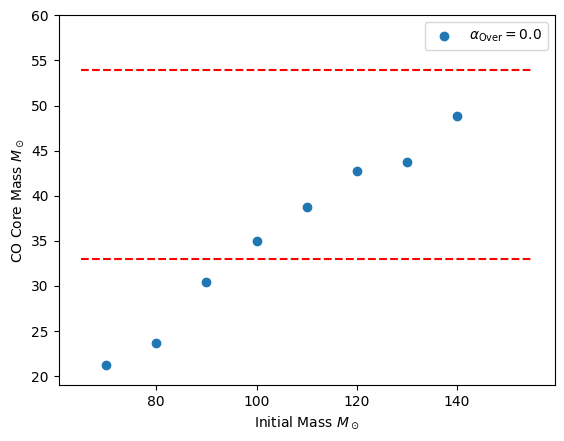

In [46]:
plt.scatter(init_mass_arr, CO_mass_core_arr, label=r'$\alpha_\mathrm{Over}=0.0$')
plt.ylabel(r'$\mathrm{CO\ Core\ Mass}\ M_\odot$')
plt.xlabel(r'$\mathrm{Initial\ Mass}\ M_\odot$')
plt.hlines([33, 54], xmin=65, xmax=155, linestyles='dashed', colors='r')
plt.ylim(19, 60)
plt.legend()

In [6]:
# physical structure